# Sentiment Analysis of Indonesian SMS Data (BERT & RoBERTa)

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

In [2]:
import sys
print(f'Python version: {sys.version}')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA version built with: {torch.version.cuda}')
    print(f'Number of GPUs: {torch.cuda.device_count()}')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i} Name: {torch.cuda.get_device_name(i)}')
else:
    print('CUDA not available. PyTorch was not built with CUDA support or the CUDA driver is not compatible.')

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version built with: 12.1
Number of GPUs: 1
GPU 0 Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
df = pd.read_csv('IDSMSA.csv')
df.head()

,Tweet Date,Sentence,Quote Count,Reply Count,Retweet Count,Favorite Count,Sentiment,English Translation
0,Thu Feb 29 11:21:27 +0000 2024,"Gk muluk muluk, 100,000 lot saham BBCA aja",0,0,0,0,Positive,"Not too ambitious, just 100,000 lots of BBCA s..."
1,Thu Feb 29 10:11:05 +0000 2024,BCA Expoversary 2024 menawarkan promo suku bun...,0,0,0,0,Neutral,BCA Expoversary 2024 offers special interest r...
2,Thu Feb 29 10:06:04 +0000 2024,[USERNAME] saham bca nya menyusul ya 🙂,0,0,0,0,Positive,[USERNAME] BCA shares will follow 🙂
3,Thu Feb 29 07:42:09 +0000 2024,PT Bank BCA Syariah (BCA Syariah) turut memeri...,0,0,0,0,Neutral,PT Bank BCA Syariah (BCA Syariah) also enliven...
4,Thu Feb 29 06:06:17 +0000 2024,[USERNAME] Begitu byk saham kamu memilih saham...,0,0,0,1,Positive,[USERNAME] So many stocks you choose those sto...


## 2. Data Preprocessing and Splitting

In [4]:
# Clean and map sentiment labels
df.dropna(subset=['Sentiment'], inplace=True)
df['Sentiment'] = df['Sentiment'].str.lower().str.strip()
label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
df['label'] = df['Sentiment'].map(label_map)
df.dropna(subset=['label'], inplace=True)
df['label'] = df['label'].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['Sentence'], 
    df['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Train set size: 2630
Test set size: 658


### How the Data is Split

We use the `train_test_split` function from the `scikit-learn` library to divide our dataset into a training set and a testing set. This is a crucial step in machine learning to ensure that we can evaluate our model on data it has never seen before.

- `test_size=0.2`: This parameter specifies that we want to allocate 20% of the data to the test set. The remaining 80% will be used for training.
- `random_state=42`: This ensures that the data is split in the same way every time the code is run. This is important for reproducibility, so we can get the same results again.
- `stratify=df['label']`: This is a very important parameter for classification tasks. It ensures that the proportion of each sentiment label (positive, neutral, negative) is the same in both the training and testing sets as it is in the original dataset. This prevents a situation where, for example, the training set has very few negative examples, which would make it difficult for the model to learn how to identify them.

## 3. BERT & RoBERTa Evaluation

### 3.1. Direct Evaluation (Without Fine-Tuning)

In [5]:
bert_model_name = 'indonesia-bert-sentiment-classification'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)

bert_pipeline = pipeline('sentiment-analysis', model=bert_model, tokenizer=bert_tokenizer)

# The model labels are different, we need to map them
bert_label_map = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}
reverse_label_map = {v: k for k, v in label_map.items()}

def predict_bert(text):
    result = bert_pipeline(text)[0]
    return label_map[bert_label_map[result['label']]]

bert_preds = [predict_bert(text) for text in tqdm(X_test)]

print("\nIndoBERT Classification Report:")
print(classification_report(y_test, bert_preds, target_names=label_map.keys()))

  0%|          | 0/658 [00:00<?, ?it/s]


IndoBERT Classification Report:
              precision    recall  f1-score   support

    positive       0.68      0.08      0.14       354
     neutral       0.25      0.93      0.39       147
    negative       0.67      0.31      0.42       157

    accuracy                           0.32       658
   macro avg       0.53      0.44      0.32       658
weighted avg       0.58      0.32      0.26       658



In [6]:
roberta_model_name = 'indonesian-roberta-base-sentiment-classifier'
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

roberta_pipeline = pipeline('sentiment-analysis', model=roberta_model, tokenizer=roberta_tokenizer)

def predict_roberta(text):
    result = roberta_pipeline(text)[0]
    # The labels from this model are already 'positive', 'neutral', 'negative'
    return label_map[result['label']]

roberta_preds = [predict_roberta(text) for text in tqdm(X_test)]

print("\nIndoRoBERTa Classification Report:")
print(classification_report(y_test, roberta_preds, target_names=label_map.keys()))

  0%|          | 0/658 [00:00<?, ?it/s]


IndoRoBERTa Classification Report:
              precision    recall  f1-score   support

    positive       0.71      0.16      0.26       354
     neutral       0.25      0.81      0.39       147
    negative       0.53      0.38      0.44       157

    accuracy                           0.35       658
   macro avg       0.50      0.45      0.36       658
weighted avg       0.57      0.35      0.33       658



### 3.2. Fine-Tuning and Evaluation

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts.iloc[item])
        label = self.labels.iloc[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for d in tqdm(data_loader, desc="Predicting"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'--- Using device: {device} ---')
EPOCHS = 10
BATCH_SIZE = 16
USE_EARLY_STOPPING = True # Set to False to train for the full number of epochs

bert_ft_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)
bert_ft_model = bert_ft_model.to(device)

train_dataset = SentimentDataset(X_train, y_train, bert_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SentimentDataset(X_test, y_test, bert_tokenizer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

optimizer = torch.optim.AdamW(bert_ft_model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)

history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0
patience = 2

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(
        bert_ft_model, train_loader, optimizer, device, scheduler, len(X_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(bert_ft_model, test_loader, device, len(X_test))
    print(f'Val loss {val_loss} accuracy {val_acc}')
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if USE_EARLY_STOPPING:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(bert_ft_model.state_dict(), 'bert_ft_model_best.bin')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break
    else:
        # If not using early stopping, save the model at every epoch
        torch.save(bert_ft_model.state_dict(), 'bert_ft_model_best.bin')

bert_ft_model.load_state_dict(torch.load('bert_ft_model_best.bin'))
y_pred, y_true = get_predictions(bert_ft_model, test_loader, device)
print("\nFine-Tuned IndoBERT Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

--- Using device: cuda:0 ---
Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 0.9496148521249944 accuracy 0.6673003802281369


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.5751138141467458 accuracy 0.7629179331306991
Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 0.39707951015143683 accuracy 0.8509505703422052


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.44914829917252064 accuracy 0.8282674772036475
Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 0.18602567774554093 accuracy 0.9368821292775665


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.6992615107225165 accuracy 0.8039513677811551
Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 0.09159863230800538 accuracy 0.973764258555133


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.9019216231924171 accuracy 0.8252279635258358
Early stopping triggered.


C:\Users\Tertius\AppData\Local\Temp\ipykernel_24404\3070140687.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_ft_model.load_state_dict(torch.load('bert_ft_model_b

Predicting:   0%|          | 0/42 [00:00<?, ?it/s]


Fine-Tuned IndoBERT Classification Report:
              precision    recall  f1-score   support

    positive       0.86      0.87      0.87       354
     neutral       0.79      0.76      0.77       147
    negative       0.78      0.81      0.80       157

    accuracy                           0.83       658
   macro avg       0.81      0.81      0.81       658
weighted avg       0.83      0.83      0.83       658



### Early Stopping

The code includes a technique called **Early Stopping**. This is what causes the training to sometimes stop before reaching the maximum number of epochs (`EPOCHS`).

**Why is it used?**
The goal of training is to help the model generalize well to new, unseen data. Sometimes, as training progresses, a model can start to *overfit*. This means it gets very good at predicting the training data but performs worse on the test data because it has essentially memorized the training examples instead of learning the underlying patterns.

**How it works in this code:**
1. We monitor the validation loss (`val_loss`) after each epoch.
2. We keep track of the `best_val_loss` seen so far.
3. If the `val_loss` for the current epoch is *not* better than the `best_val_loss`, we increment a `patience_counter`.
4. If the `val_loss` fails to improve for a specified number of epochs (defined by `patience = 2`), we assume the model is no longer improving and we stop the training early.
5. The best version of the model (the one with the lowest validation loss) is saved and used for the final evaluation.

You can disable this behavior by setting `USE_EARLY_STOPPING = False` in the code cell above. When it is `False`, the model will train for all 10 epochs.

(0.0, 1.0)

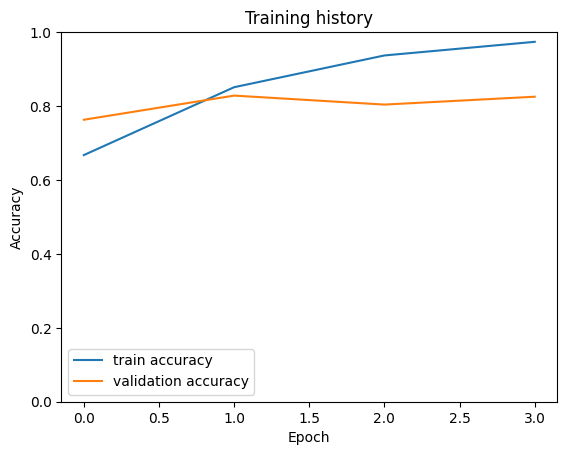

In [10]:
# Use a list comprehension to move each tensor in the list to the CPU
train_acc_cpu = [t.cpu() for t in history['train_acc']]
val_acc_cpu = [t.cpu() for t in history['val_acc']]

plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')

# The rest of your plotting code remains the same
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [11]:
roberta_ft_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)
roberta_ft_model = roberta_ft_model.to(device)

train_dataset_roberta = SentimentDataset(X_train, y_train, roberta_tokenizer)
train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_roberta = SentimentDataset(X_test, y_test, roberta_tokenizer)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=BATCH_SIZE)

optimizer_roberta = torch.optim.AdamW(roberta_ft_model.parameters(), lr=2e-5)
total_steps_roberta = len(train_loader_roberta) * EPOCHS
scheduler_roberta = get_linear_schedule_with_warmup(
    optimizer_roberta,
    num_warmup_steps=int(total_steps_roberta * 0.1),
    num_training_steps=total_steps_roberta
)

history_roberta = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
best_val_loss_roberta = float('inf')
patience_counter_roberta = 0
patience = 2

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(
        roberta_ft_model, train_loader_roberta, optimizer_roberta, device, scheduler_roberta, len(X_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(roberta_ft_model, test_loader_roberta, device, len(X_test))
    print(f'Val loss {val_loss} accuracy {val_acc}')
    
    history_roberta['train_acc'].append(train_acc)
    history_roberta['train_loss'].append(train_loss)
    history_roberta['val_acc'].append(val_acc)
    history_roberta['val_loss'].append(val_loss)
    
    if USE_EARLY_STOPPING:
        if val_loss < best_val_loss_roberta:
            best_val_loss_roberta = val_loss
            patience_counter_roberta = 0
            torch.save(roberta_ft_model.state_dict(), 'roberta_ft_model_best.bin')
        else:
            patience_counter_roberta += 1
            if patience_counter_roberta >= patience:
                print('Early stopping triggered.')
                break
    else:
        torch.save(roberta_ft_model.state_dict(), 'roberta_ft_model_best.bin')

roberta_ft_model.load_state_dict(torch.load('roberta_ft_model_best.bin'))
y_pred_roberta, y_true_roberta = get_predictions(roberta_ft_model, test_loader_roberta, device)
print("\nFine-Tuned IndoRoBERTa Classification Report:")
print(classification_report(y_true_roberta, y_pred_roberta, target_names=label_map.keys()))

Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 1.0215510906595173 accuracy 0.6608365019011406


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.5327637351694561 accuracy 0.776595744680851
Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 0.43376943035559223 accuracy 0.8376425855513308


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.47350673129161197 accuracy 0.8085106382978723
Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 0.2328894628155412 accuracy 0.9220532319391634


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.673808087905248 accuracy 0.8054711246200608
Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train loss 0.1408843213388922 accuracy 0.9574144486692014


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Val loss 0.7085991038807801 accuracy 0.8297872340425532
Early stopping triggered.


C:\Users\Tertius\AppData\Local\Temp\ipykernel_24404\1382131119.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  roberta_ft_model.load_state_dict(torch.load('roberta_ft_m

Predicting:   0%|          | 0/42 [00:00<?, ?it/s]


Fine-Tuned IndoRoBERTa Classification Report:
              precision    recall  f1-score   support

    positive       0.85      0.87      0.86       354
     neutral       0.76      0.71      0.73       147
    negative       0.75      0.76      0.76       157

    accuracy                           0.81       658
   macro avg       0.79      0.78      0.78       658
weighted avg       0.81      0.81      0.81       658



(0.0, 1.0)

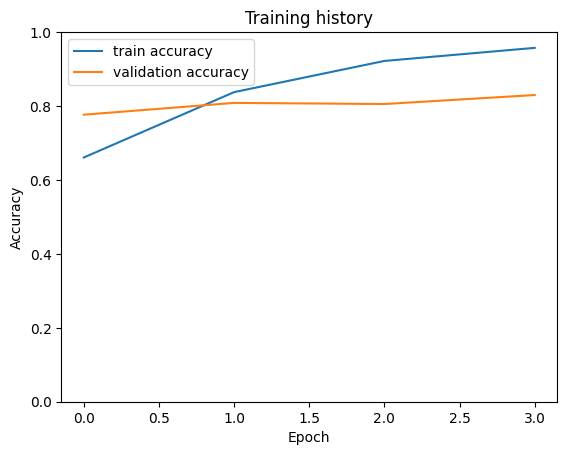

In [12]:
# Use a list comprehension to move each tensor in the list to the CPU
train_acc_cpu = [t.cpu() for t in history_roberta['train_acc']]
val_acc_cpu = [t.cpu() for t in history_roberta['val_acc']]

plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')

# The rest of your plotting code remains the same
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

## 4. Conclusion

In [13]:
# Get accuracy scores
bert_accuracy = accuracy_score(y_test, bert_preds)
roberta_accuracy = accuracy_score(y_test, roberta_preds)
bert_ft_accuracy = accuracy_score(y_true, y_pred)
roberta_ft_accuracy = accuracy_score(y_true_roberta, y_pred_roberta)

conclusion_data = {
    'Model': ['IndoBERT', 'IndoRoBERTa', 'IndoBERT (Fine-Tuned)', 'IndoRoBERTa (Fine-Tuned)'],
    'Accuracy': [bert_accuracy, roberta_accuracy, bert_ft_accuracy, roberta_ft_accuracy]
}

conclusion_df = pd.DataFrame(conclusion_data)
print(conclusion_df.sort_values(by='Accuracy', ascending=False))

print("\n## Conclusion\n")
print("The table above summarizes the accuracy of the four different approaches. Based on the results, we can determine which model and approach works best for this dataset.")
print("\nAs a reminder, the classification reports are generated using the **test data**. This provides an unbiased evaluation of how the models perform on new, unseen data, which is the standard practice for assessing a model's true performance.")

                      Model  Accuracy
2     IndoBERT (Fine-Tuned)  0.828267
3  IndoRoBERTa (Fine-Tuned)  0.808511
1               IndoRoBERTa  0.354103
0                  IndoBERT  0.322188

## Conclusion

The table above summarizes the accuracy of the four different approaches. Based on the results, we can determine which model and approach works best for this dataset.

As a reminder, the classification reports are generated using the **test data**. This provides an unbiased evaluation of how the models perform on new, unseen data, which is the standard practice for assessing a model's true performance.
